<a href="https://colab.research.google.com/github/mayankraj25/Sentimental-Analysis-of-user-reviews/blob/main/Sentiment_Analysis_of_user_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mayankraj1365","key":"251b020fd999c6d3d372e8edd059baea"}'}

In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d snap/amazon-fine-food-reviews


Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0


In [3]:
!unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [4]:
import pandas as pd
df = pd.read_csv('Reviews.csv')

In [5]:
# Step 1: Keep only relevant columns
df = df[['Text', 'Score']].dropna()

# Step 2: Filter out neutral reviews (Score = 3) and label sentiment
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].apply(lambda x: 'positive' if x > 3 else 'negative')

# Step 3: Clean the review text
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned'] = df['Text'].apply(clean_text)

# Step 4: Train-Test Split
from sklearn.model_selection import train_test_split

X = df['cleaned']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Vectorization (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Step 6: Train a Logistic Regression Model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Step 7: Evaluate the Model
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 8: Predict Custom Review Sentiment
def predict_sentiment(review_text):
    cleaned = clean_text(review_text)
    vect = vectorizer.transform([cleaned])
    prediction = model.predict(vect)
    return prediction[0]

# Example test
example_review = "This product is amazing! It exceeded all my expectations."
print("\nExample Review:", example_review)
print("Predicted Sentiment:", predict_sentiment(example_review))


Accuracy: 0.9336078278481975

Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.70      0.77     16379
    positive       0.95      0.98      0.96     88784

    accuracy                           0.93    105163
   macro avg       0.90      0.84      0.86    105163
weighted avg       0.93      0.93      0.93    105163


Example Review: This product is amazing! It exceeded all my expectations.
Predicted Sentiment: positive


In [6]:
import joblib

# Save trained model and vectorizer
joblib.dump(model, 'model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [7]:
from google.colab import files

# Download the model and vectorizer files to your local system
files.download('model.pkl')
files.download('vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(np.float64(-1.0999999956390651),
 np.float64(1.0999999262958242),
 np.float64(-1.099999835474617),
 np.float64(1.099999953223866))

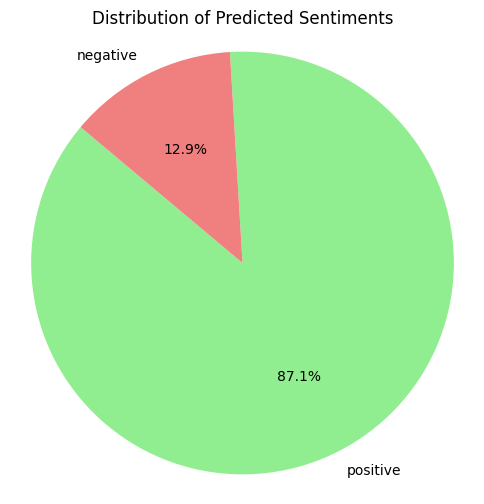

In [8]:
import matplotlib.pyplot as plt

# Count predicted sentiments
pred_counts = pd.Series(y_pred).value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(pred_counts, labels=pred_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'], startangle=140)
plt.title('Distribution of Predicted Sentiments')
plt.axis('equal')

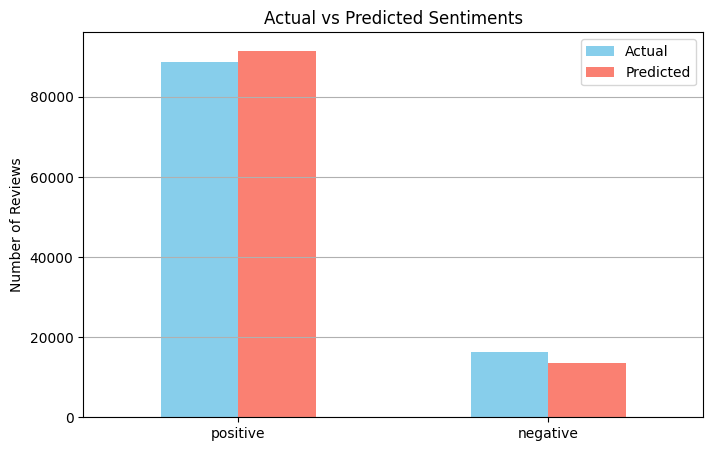

In [9]:
import seaborn as sns

# Count actual and predicted
actual_counts = y_test.value_counts()
predicted_counts = pd.Series(y_pred).value_counts()
compare_df = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts})

# Bar chart
compare_df.plot(kind='bar', figsize=(8,5), color=['skyblue', 'salmon'])
plt.title('Actual vs Predicted Sentiments')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [11]:
import joblib

# Save model and vectorizer
joblib.dump(model, 'model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')
from flask import Flask, request, jsonify
import joblib
import re

# Load model and vectorizer
model = joblib.load("model.pkl")
vectorizer = joblib.load("vectorizer.pkl")

# Text cleaning (same as before)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json()
    review = clean_text(data['review'])
    vect = vectorizer.transform([review])
    prediction = model.predict(vect)[0]
    return jsonify({'sentiment': prediction})

if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
